In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict

In [2]:
def read_log_file(log):
    res = {}
    with open(log, 'r') as f:
        for line in f:
            if bool(re.search('epoch [0-9]+', line)):
                split = re.search('epoch [0-9]+ - ([A-Za-z]+)', line).groups()[0]
                if split not in res:
                    res[split] = defaultdict(list)
                metrics = re.search('epoch.*(loss.*)', line).groups()[0].split(',')
                metrics = [x.strip().split(':') for x in metrics]
                for metric, metric_value in metrics:
                    if not '=' in metric_value:
                        metric_value = float(metric_value)
                    res[split][metric].append(metric_value)
    return res

In [3]:
data_dir='/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/'

log=data_dir+'state_space/species-agnostic/log'
log=data_dir+'dnabert2-3utr/log'

#
#log='/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/dnabert-3utr/default/log'

In [4]:
log

'/lustre/groups/epigenereg01/workspace/projects/vale/mlm/models/dnabert2-3utr/log'

In [5]:
res = read_log_file(log)

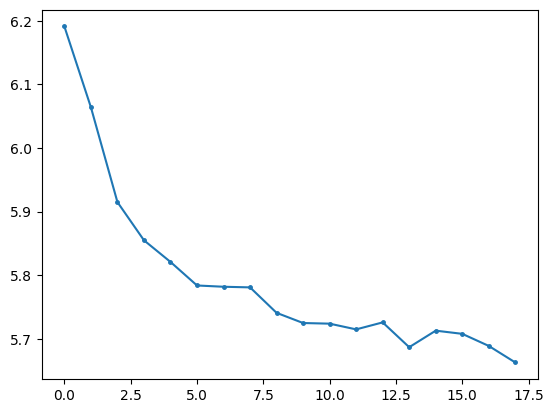

In [6]:
fig, ax = plt.subplots()

ax.plot(res['train']['loss'],marker='.',markersize=5)
#ax.set_ylim([2.2,3])